블랙-숄즈 공식 : 파생 상품 가격 채정에 널리 사용되는 모델

중점 내용
- 파생 상품 가격 책정을 위한 머신러닝 기반 프레임워크 개발
- 파생 상품 가격 책정에서 선형 지도 회귀 및 비선형 지도 회귀 모델 비교

지도회귀 프레임워크

예측되는 변수: 옵션가격

예측변수:시장데이터(블랙-숄즈 가격 책정모델 입력값)

In [11]:
# 지도 회귀 모델을 위한 함수와 모듈
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

In [12]:
# 데이터 분석 및 모델 평가를 위한 함수 모듈
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

In [15]:
# 딥러닝 모델을 위한 함수와 모듈
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import sgd_experimental
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

In [1]:
# 함수 및 매개변수 정의
true_alpha=0.1
true_beta=0.1
true_sigma0=0.2

In [2]:
# 이자율(예측변수)정의
risk_free_rate=0.05

In [20]:
from scipy.stats import norm

In [21]:
# 옵션의 변동성과 가격책정 함수

def option_vol_from_surface(moneyness, time_to_maturity):
  return true_sigma0 + true_alpha*time_to_maturity + true_beta * np.square(moneyness-1)
def call_option_price(moneyness, time_to_maturity, option_vol):
  d1=(np.log(1/moneyness)+(risk_free_rate+np.square(option_vol))*
      time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
  d2=(np.log(1/moneyness)+(risk_free_rate-np.square(option_vol))*
      time_to_maturity)/(option_vol*np.sqrt(time_to_maturity))
  N_d1=norm.cdf(d1)
  N_d2=norm.cdf(d2)
  return N_d1-moneyness*np.exp(-risk_free_rate*time_to_maturity)*N_d2

데이터 생성
만기일:Ts
옵션 가격도:Ks
변동성:sigma

In [24]:
import numpy as np
import pandas as pd

In [22]:
# 데이터 생성
N=10000
Ks=1+0.25*np.random.randn(N)
Ts=np.random.random(N)
Sigmas=np.array([option_vol_from_surface(k,t) for k,t in zip(Ks,Ts)])
Ps=np.array([call_option_price(k,t,sig) for k,t,sig in zip(Ks,Ts,Sigmas)])

In [28]:
# 예측되는 변수와 예측변수 생성
Y=Ps
X=np.concatenate([Ks.reshape(-1,1), Ts.reshape(-1,1), Sigmas.reshape(-1,1)],axis=1)
dataset=pd.DataFrame(np.concatenate([Y.reshape(-1,1),X], axis=1),
                     columns=['Price','Moneyness','Time','Vol'])

In [29]:
dataset
# 모델의 특성변수: 옵션가격(price), 예측되는 변수 옵션 가격도(moneyness), 만기일(time to maturity), 변동성(volatility)

,Price,Moneyness,Time,Vol
0,0.201623,1.023851,0.787024,0.278759
1,0.047335,1.391829,0.611601,0.276513
2,0.167271,0.836485,0.083500,0.211024
3,0.169849,1.073690,0.727218,0.273265
4,0.106458,1.081292,0.451619,0.245823
...,...,...,...,...
9995,0.229471,1.020765,0.915486,0.291592
9996,0.353151,0.648415,0.048358,0.217197
9997,0.240457,0.763121,0.093896,0.215001
9998,0.340271,0.767546,0.940940,0.299497


In [32]:
# 데이터 시각화 패키지
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf

<Figure size 1080x1080 with 0 Axes>

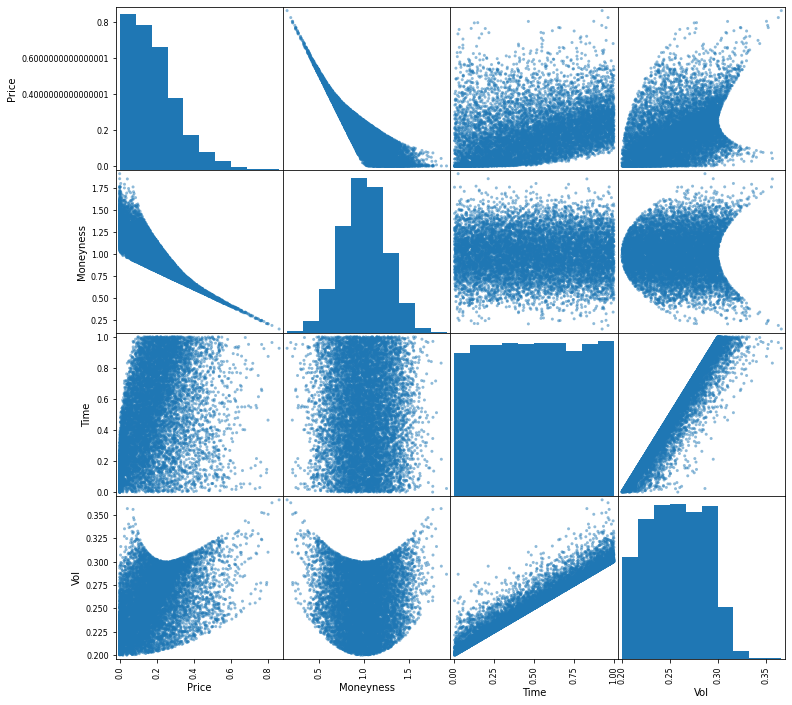

In [33]:
# 데이터 시각화 (변수간의 상호작용)
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

In [35]:
# 특성의 중요도 파악
bestfeatures=SelectKBest(k='all',score_func=f_regression)
fit=bestfeatures.fit(X,Y)
dfscores=pd.DataFrame(fit.scores_)
dfcolumns=pd.DataFrame(['Moneyness','Time','Vol'])

# 더 나은 시각화를 위해 두 개의 데이터프레임 연결
featureScores=pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns=['Specs','Score']
# 데이터프레임 열 이름 지정
featureScores.nlargest(10,'Score').set_index('Specs')

,Score
Specs,
Moneyness,30999.950200
Vol,2391.982293
Time,1511.486389


옵션 가격에서는 옵션 가격도가 가장 중요한 변수이고 그 다음이 변동성과 만기일.
변수가 세개뿐이라 모델링에 모두 포함

In [36]:
# 훈련

# train/test 나누기
validation_size=0.2
train_size=int(len(X)*(1-validation_size))
X_train, X_test = X[0:train_size],X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size],Y[train_size:len(X)]

In [43]:
# K-겹 분석, 평가 메트릭 매개변수 정의
num_folds=7
seed=10
scoring='neg_mean_squared_error'

In [40]:
# 모델 및 알고리즘 비교 (지도 회귀 모델군에서)

# 선형 모델과 회귀 트리
models=[]
models.append(('LR', LinearRegression()))
models.append(('KNN',KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR',SVR()))

In [41]:
# 인공신경망
models.append(('MLP',MLPRegressor()))

# 부스팅과 배깅 방법
# 부스팅 방법
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))

# 배깅 방법
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))



In [46]:
# 모든 모델 선택한 수 모델마다 반복수행
# 평가 메트릭의 평균과 표준편차 계산

names=[]
kfold_results=[]
test_results=[]
train_results=[]
for name, model in models:
  names.append(name) ## k-겹 분석
  kfold=KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  # 평균제곱 오차를 양수로 변환
  cv_results= -1*cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  kfold_results.append(cv_results)
  # 총 훈련기간
  res=model.fit(X_train, Y_train)
  train_result=mean_squared_error(res.predict(X_train), Y_train)
  train_results.append(train_result)

  # 테스트 결과
  test_result=mean_squared_error(res.predict(X_test),Y_test) 
  test_results.append(test_result)

<function matplotlib.pyplot.show>

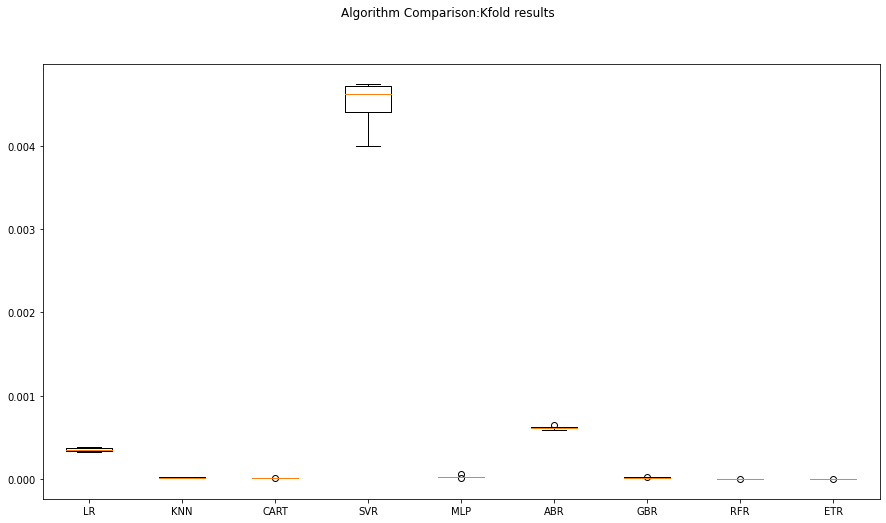

In [50]:
# 교차 검증 결과
fig=pyplot.figure()
fig.suptitle('Algorithm Comparison:Kfold results')
ax=fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show

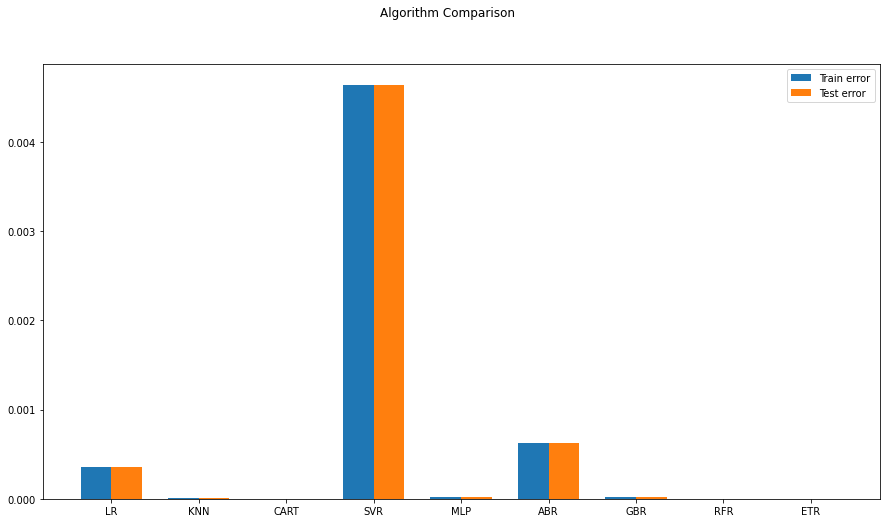

In [52]:
# 알고리즘 비교
fig=pyplot.figure()
ind=np.arange(len(names))
width=0.35
fig.suptitle('Algorithm Comparison')
ax=fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results, width=width, label='Train error')
pyplot.bar(ind + width/2, train_results, width=width, label='Test error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

In [56]:
# 모델 튜닝 및 모델 확정

param_grid={'hidden_layer_sizes':[(20,),(50,),(20,20),(20,30,20)]}
model=MLPRegressor()
kfold=KFold(n_splits=num_folds, random_state=seed, shuffle=True) #shuffle=True로 해야함
grid=GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold) # 은닉층에 대한 격자탐색 수행
grid_result=grid.fit(X_train, Y_train)
print("Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))
means=grid_result.cv_results_['mean_test_score']
stds=grid_result.cv_results_['std_test_score']
params=grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000035 using {'hidden_layer_sizes': (20, 30, 20)}
-0.000731 (0.000551) with: {'hidden_layer_sizes': (20,)}
-0.000344 (0.000428) with: {'hidden_layer_sizes': (50,)}
-0.000062 (0.000049) with: {'hidden_layer_sizes': (20, 20)}
-0.000035 (0.000022) with: {'hidden_layer_sizes': (20, 30, 20)}


In [58]:
# 훈련셋에 대한 성능 확인
# 모델 준비
model_tuned=MLPRegressor(hidden_layer_sizes=(20,30,20))
model_tuned.fit(X_train, Y_train)

predictions=model_tuned.predict(X_test)
print(mean_squared_error(Y_test, predictions))

3.555775373103878e-05
